In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import scipy as sp
import os

from skimage import img_as_float
from skimage.morphology import reconstruction, h_maxima, h_minima
from skimage import morphology

import torch


In [2]:
# An Unsupervised Approach for Overlapping Cervical Cell Cytoplasm Segmentation

## 1) Cell clump segmentation
### - median filter (5 x 5)
### - adaptive histogram equalization
### - Cytoplasm: OTSU filtering
### - Nucleus: Global-Mean Threshold

## 2) Modified OTSU method with class prior probablility
### - OTSU and class prior probability (pixel * 0.05)

## 3) Cytoplasm segmentation
### - the distance regularized level set evolution

In [3]:
pathdir = '../images/LBC01/'
pathlist = [pathdir + p for p in os.listdir(pathdir)]
pathlist[0:5]

['../images/LBC01/LBC01-20210102(1)_228.png',
 '../images/LBC01/LBC01-20210102(1)_1771.png',
 '../images/LBC01/LBC01-20210102(1)_814.png',
 '../images/LBC01/LBC01-20210102(1)_378.png',
 '../images/LBC01/LBC01-20210102(1)_1268.png']

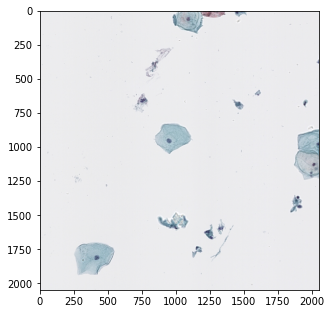

In [4]:
# img = cv2.imread("../../Dataset/papsmear/isbi2015/Training/frame014_stack/fov000.png")
img = cv2.imread(pathlist[100])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 10))
plt.imshow(img);

(2048, 2048)
False


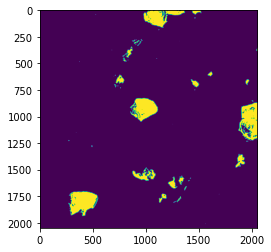

In [23]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
print(gray.shape)
# plt.imshow(gray);
gray = cv2.medianBlur(gray,7)
bit_map = gray < 200
print(bit_map[0][1000])
removed_img = morphology.remove_small_objects(~bit_map, min_size=10000)
gray1 = bit_map * gray
plt.imshow(bit_map)

In [33]:
import numpy as np

def conv2d_np(image, kernel):
    kernel = np.flipud(np.fliplr(kernel)) #XCorrel
    
    sub_matrices = np.lib.stride_tricks.as_strided(image,
                                                   shape = tuple(np.subtract(image.shape, kernel.shape))+kernel.shape, 
                                                   strides = image.strides * 2)

    return np.einsum('ij,klij->kl', kernel, sub_matrices)

In [38]:
kernel = [[1,1,1], [1,1,1], [1,1,1]]
conv2d_np(bit_map, kernel)
np.pad(bit_map, (3,3), 'constant', constant_values=0).shape

(2054, 2054)

In [37]:
np.array(conv2d_np(bit_map, kernel)).shape

(2045, 2045)

In [15]:
bit_map

array([0, 0, 0, 0, 0])

[167 166 159 149 141 141 145 150 155 160]


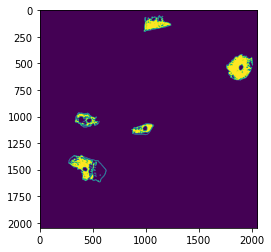

In [198]:
# img = cv2.imread(pathlist[50])
# gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# # plt.imshow(gray_img)
# # print(gray_img[0][0])
# bit_map = gray_img < 200
# # plt.imshow(bit_map)
# removed_img = morphology.remove_small_objects(bit_map, min_size=10000)
# # plt.imshow(removed_img)
# # print(removed_img)

# # plt.imshow(np.expand_dims(removed_img, axis=2) * img)
# g_image = removed_img * gray_img
# print(g_image[1500][500:510])
# plt.imshow(removed_img * gray_img)
# # plt.imshow(img)

# # ret, thresh_cv = cv2.threshold(gray_img, -1, 255,  cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# # gray_img = gray_img > 200
# # plt.imshow(gray_img * bit_map)
# neucli_bit_map = g_image > 160
# plt.imshow(neucli_bit_map)

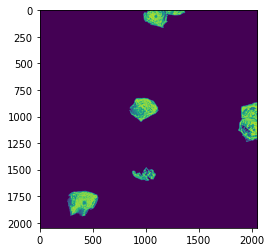

In [215]:
img = cv2.imread(pathlist[100])

bit_map = img < 200
# plt.imshow(bit_map)
removed_img = morphology.remove_small_objects(bit_map, min_size=25000)
# print(removed_img)
new_img = removed_img * img
# print(new_img)
gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

(-0.5, 2047.5, 2047.5, -0.5)

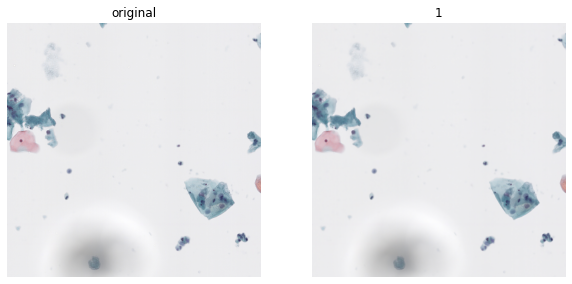

In [47]:
# 일반 Blur
img = cv2.imread(pathlist[450])
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img1 = cv2.blur(img,(5,5))
# GaussianBlur
img2 = cv2.GaussianBlur(img,(5,5),0)
# Median Blur
img3 = cv2.medianBlur(img,9)
# Bilateral Filtering
img4 = cv2.bilateralFilter(img,9,75,75)

fig = plt.figure(figsize=(10,10))
rows = 1
cols = 2

ax0 = fig.add_subplot(rows, cols, 1)
ax0.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax0.set_title('original')
ax0.axis("off")

ax1 = fig.add_subplot(rows, cols, 2)
ax1.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax1.set_title('1')
ax1.axis("off")


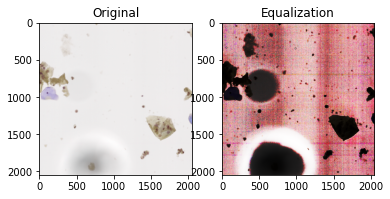

In [58]:
hist, bins = np.histogram(img1.flatten(), 256,[0,256])
cdf = hist.cumsum()
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

img2 = cdf[img1]
plt.subplot(121),plt.imshow(img1),plt.title('Original')
plt.subplot(122),plt.imshow(img2),plt.title('Equalization')
plt.show()

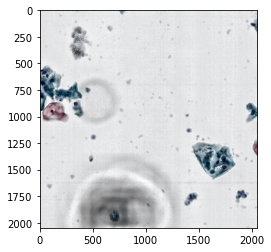

In [141]:
gridsize = 24
lab = cv2.cvtColor(img1, cv2.COLOR_BGR2LAB)
lab_planes = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=10.0,tileGridSize=(gridsize,gridsize))
lab_planes[0] = clahe.apply(lab_planes[0])
lab = cv2.merge(lab_planes)
bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
img2 = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img2)

In [127]:
# gray_image = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# cl1 = clahe.apply(gray_image)
# res = np.hstack((gray_image,cl1)) #stacking images side-by-side
# # cv2.imshow('img', res)
# plt.imshow(cl1)
# # cv2.waitKey()
# # cv2.destroyAllWindows()

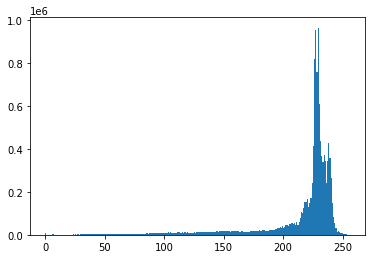

In [142]:
# hist = cv2.calcHist([img2[2]], [0], None, [256], [0,256])
plt.hist(img2.ravel(), 256, [0,256])
plt.show()

In [75]:
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
import numpy as np
from skimage.morphology import h_maxima

In [112]:
w = 10
x, y = np.mgrid[0:w,0:w]
# print(x)
# print(y)
f = 20 - 0.2*((x - w/2)**2 + (y-w/2)**2)
f[2:4,2:4] = 40; f[2:4,7:9] = 60; f[7:9,2:4] = 80; f[7:9,7:9] = 100
f = f.astype(int)
print(f)
# We can calculate all maxima with a height of at least 40:
maxima = h_maxima(f, 30)
maxima


[[ 10  11  13  14  14  15  14  14  13  11]
 [ 11  13  15  16  16  16  16  16  15  13]
 [ 13  15  40  40  18  18  18  60  60  15]
 [ 14  16  40  40  19  19  19  60  60  16]
 [ 14  16  18  19  19  19  19  19  18  16]
 [ 15  16  18  19  19  20  19  19  18  16]
 [ 14  16  18  19  19  19  19  19  18  16]
 [ 14  16  80  80  19  19  19 100 100  16]
 [ 13  15  80  80  18  18  18 100 100  15]
 [ 11  13  15  16  16  16  16  16  15  13]]


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

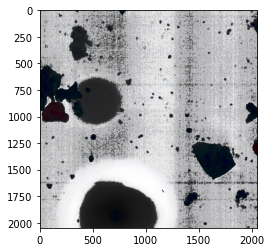

In [138]:
# # gridsize = 8
# lab = cv2.cvtColor(img1, cv2.COLOR_BGR2LAB)
# lab_planes = cv2.split(lab)
# # clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
# # lab_planes[0] = clahe.apply(lab_planes[0])
# lab_planes[0] = cv2.equalizeHist(lab_planes[0])
# lab = cv2.merge(lab_planes)
# bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
# img2 = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
# plt.imshow(img2)
# # plt.imshow(h_maxima(img2, 5))

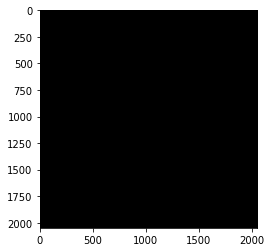

In [133]:
plt.imshow(h_maxima(img1, 5))

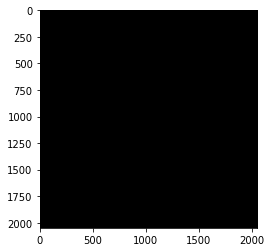

In [99]:
plt.imshow(h_image)

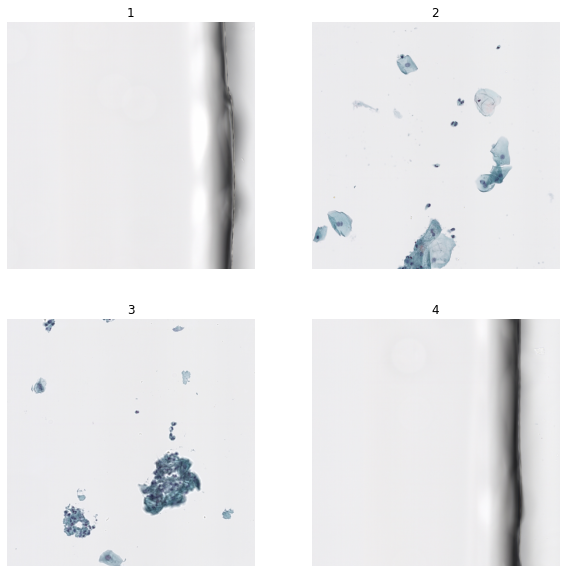

In [24]:
# fig = plt.figure(figsize=(10,10))
# rows = 2
# cols = 2
# num = 495

# img1 = cv2.imread(pathlist[num])
# img2 = cv2.imread(pathlist[num+1])
# img3 = cv2.imread(pathlist[num+2])
# img4 = cv2.imread(pathlist[num+3])
# ax1 = fig.add_subplot(rows, cols, 1)
# ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
# ax1.set_title('1')
# ax1.axis("off")
# ax2 = fig.add_subplot(rows, cols, 2)
# ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
# ax2.set_title('2')
# ax2.axis("off")
# ax3 = fig.add_subplot(rows, cols, 3)
# ax3.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
# ax3.set_title('3')
# ax3.axis("off")
# ax4 = fig.add_subplot(rows, cols, 4)
# ax4.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
# ax4.set_title('4')
# ax4.axis("off")
# plt.show()